# <center>Parallélisation du Filtre de Kalman </center>
### <center> *BLANCHARD Eléonore, DEGUY Inès* </center> 

In [0]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Introduction

Ce projet a pour étude la parallélisation d'un algorithme séquentiel dans le but d'améliorer considérablement son temps d'exécution. Dans le cadre du Machine Learning, les données peuvent très vite devenir énormes et les algorithmes qui utilisent une approche séquentielle deviennent alors peu performant. La parallélisation permet une réduction considérable du temps d'exécution. Elle consiste à utiliser plusieurs processeurs (threads) à la place d'un seul processeur, les calculs effectués par l'algorithme seront alors dirigés vers un ensemble de processeurs à la place d'un seul. Il existe plusieurs manières de diminuer le temps d'exécution de ses algorithmes en les parallélisant. On peut paralléliser un algorithme en utilisant Cython, la programmation GPU ou Spark. Dans ce projet nous avons choisi d'utiliser Cython pour paralléliser notre algorithme séquentiel et nous avons aussi choisi de travailler sur la construction d'un algorithme du filtre de Kalman, très utilisé dans l'étude des séries temporelles dans des domaines tels que la finance, l'économie et le traitement du signal. 


## 2. Motivation 

Le but du projet est de construire un algorithme séquentiel puis de réussir à le paralléliser et enfin de comparer les temps d'exécution des algorithmes séquentiel et parallélisé. Nous avons aussi voulu pouvoir comparer nos algorithmes avec le temps d'exécution de la bibliothéque Numpy. 

Pour pouvoir paralléliser nos algorithmes nous avons implémenté des fonctions sans l'utilisation de Numpy ou autres bibliothèques. Une fois la fonction séquentielle créé, nous avons implémenté sa version paralléliser. Enfin, pour toutes les fonctions qui nous serviront à construire notre filtre de Kalman, nous avons comparé le temps d'exécution de la version séquentielle, de la version paralléliser et de la fonction disponible dans Numpy. Une fois les fonctions implémentées, nous avons créé notre algorithme de filtre de Kalman de trois façons différentes: une utilisant les fonctions séquentielles, les fonctions paralléliser et les fonctions de Numpy.  

Notre projet se déroulera donc de la façon suivante, premièrement une partie traitera de la création de ses fonctions et de la comparaison de leur temps d'exécution. Puis, on implémentera le filtre de Kalman et une application de ce filtre.

## 3. Présentation du filtre de Kalman


Le filtre de Kalman est une méthode visant à estimer des paramètres d'un système évoluant dans le temps à partir de mesures bruitées. L'avantage de ce modèle par rapport à d'autres méthodes d'estimation telle qu'une simple régression linéaire est sa capacité de prédiction des paramètres et de rectification des erreurs.
Dans ce projet nous utiliseront un filtre de Kalman en temps discret et sur une estimation linéaire des paramètres.

On distingue deux phases dans le filtre de Kalman : la phase de prédiction et la phase de mise à jour. 

1.   **La phase de prédiction utilise l'état estimé de l'instant précédent pour produire une estimation de l'état courant.**
2.   **L'étape de mise à jour, les observations de l'instant courant sont utilisées pour corriger l'état prédit dans le but d'obtenir une estimation plus précise.**

Supposons que la série temporelle $y_{t}$, représentée par le vecteur $(y_{0}, y_{1},…,y_{n})$ soit observable et dépend de la variable $x_{t}$ qui n'est pas observable. Il faudra alors simuler sa valeur et sa variance $w_{t}$ dont nous ne connaissons pas la valeur non plus. 

Le modèle se présente donc comme suit :

$x_{t}=a_{1}+a_{2}x_{t-1} + n_{t-1}$   

$y_{t}=b_{1}+b_{2}x_{t} + e_{t}$

$a_{i}$ et $b_{i}$ sont les paramètres à estimer, $n$ et $e$ sont des bruits gaussiens.

La première équation est appelée équation d'état et la deuxième équation de mesure.  

 
**Étape 1 : étape de la prévision**

Nous calculons les deux prévisions suivantes:
 
$x_{t/t-1}=a_{1,t-1}+a_{2,t-1}x_{t-1}$ 

$w_{t/t-1}=c^2_{1,t-1}w_{t-1} + var(e_{t})$

**Étape 2 : étape de la révision**

On dispose en $t$ d'une nouvelle observation $y_{t}$, on l'utilise pour calculer l'erreur de prévision $v_{t}$ et la variation suivante $w_{t}$: 


$v_{t}=y_{t}-a_{1}-a_{2}x_{t/t-1}$

$var(v_{t})=v_{t}+a^2_{2,t-1}w_{t/t-1}$


On utilise $v_{t}$ et $var(v_{t})$ pour pouvoir mettre à jour $x_{t}$et sa variance $w_{t}$.

$x_{t}= x_{t/t-1}+\frac{a_{2,t-1}w_{t/t-1}v_{t}}{var(v_{t})} $

$w_{t}= w_{t/t-1}+\frac{a^2_{2,t-1}w^2_{t/t-1}}{var(v_{t})} $

On aura recourt à une méthode du maximum de vraissemblance pour estimer les paramètres.

In [0]:
%load_ext cython

In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd 

## 4. Calcul matriciel

### Fonction Dot

**`mat_dot(a, b)`** : Calcule le produit scalaire de deux matrices `a` et `b`.

**Code séquentiel**

In [0]:
def s_mat_dot(a, b):
    n = a.shape[0]
    p = a.shape[1]
    q = b.shape[1]
    
    res = np.zeros((n,q))
    
    for i in range(n):
        for j in range(q):
            res[i,j] = 0
            for k in range(p):
                res[i,j] += a[i,k] * b[k,j]
    return res 

**Code parallélisé**

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_dot(double[:,:] a, double[:, :] b, double[:,:] res):
    cdef int n, p, q
    n = a.shape[0]
    p = a.shape[1]
    q = b.shape[1]

    cdef int i, j, k 
    # parallélisation
    with cython.nogil, parallel():
        for i in prange(n):
            for j in prange(q):
                res[i,j] = 0
                for k in prange(p):
                    res[i,j] += a[i,k] * b[k,j]
    
    return res

**Test de vitesse**

In [0]:
u = np.random.random((10,20))
v = np.random.random((20,5))
res = np.zeros((u.shape[0], v.shape[1]))

In [0]:
%timeit s_mat_dot(u, v)

2.71 ms ± 661 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [0]:
%timeit p_mat_dot(u, v, np.zeros((u.shape[0], v.shape[1])))

16.2 µs ± 4.89 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
%timeit np.dot(u, v)

7.36 µs ± 833 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Mesure et Graphique**

   Résultats séquentiel Résultats parallèle Résultats numpy
1           8.32081e-05         0.000143528      0.00401759
2            0.00020647         3.29018e-05     2.09808e-05
3           0.000221014         2.21729e-05     1.35899e-05
4            0.00024724         1.78814e-05     1.12057e-05
5           0.000296354         1.71661e-05     1.00136e-05
6           0.000363827          1.4782e-05     9.53674e-06
7            0.00046587         2.45571e-05     1.71661e-05
8           0.000466585         1.74046e-05     1.19209e-05
9           0.000497341         1.66893e-05     1.00136e-05
10          0.000570774         1.71661e-05     9.53674e-06
11          0.000620127         1.74046e-05     9.77516e-06
12           0.00067997         1.64509e-05     9.77516e-06
13           0.00073123         1.88351e-05     1.26362e-05
14          0.000776052         1.69277e-05     1.14441e-05
15          0.000798941         1.78814e-05     1.09673e-05
16          0.000847816         1.74046e

Text(0.5, 1.0, 'Sequential / Parallel / numpy dot')

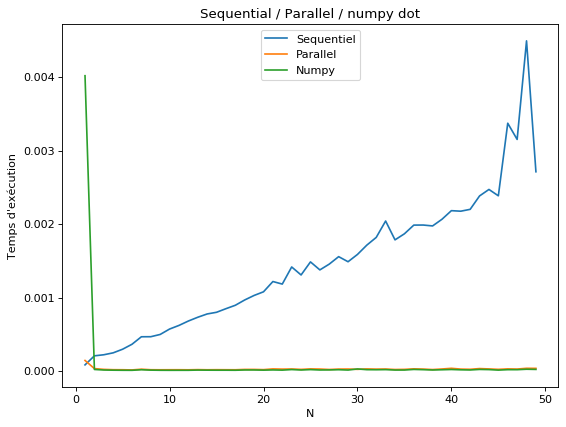

In [5]:
time_f=np.zeros(3)
nmax=50
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
    va = np.random.random((10,n))
    vb = np.random.random((n,5))
    res = np.zeros((va.shape[0], vb.shape[1]))

    time_f[0]=time.time()
    s_mat_dot(va, vb)
    time_f[0]=time.time()-time_f[0]

    time_f[1]=time.time()
    p_mat_dot(va, vb,res)
    time_f[1]=time.time()-time_f[1]

    time_f[2]=time.time()
    np.dot(va, vb)
    time_f[2]=time.time()-time_f[2]

    df.iloc[n-1,0]=time_f[0]
    df.iloc[n-1,1]=time_f[1]
    df.iloc[n-1,2]=time_f[2]

print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy dot")

### Fonction Diag

**`mat_diag(vec)`** : Construit la matrice diagonale dont les valeurs sur la diagonales correspondent au vecteur `vec`.

**Code séquentiel**

In [0]:
def s_mat_diag(vec):
    n = len(vec)
    res = np.zeros((n,n))
    
    for i in range(n):
        res[i,i] = vec[i]
        
    return res

**Code parallélisé**

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_diag(double[:] vec, double[:,:] res):
    cdef int n 
    n = len(vec)
    
    cdef int i
    # parallélisation
    with cython.nogil, parallel():
        for i in prange(n):
            res[i,i] = vec[i]
    
    return res

**Test de vitesse**

In [0]:
n = 20
a = np.random.random(n)
res = np.zeros((n,n))

In [0]:
%timeit s_mat_diag(a)

29.4 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [0]:
%timeit p_mat_diag(a,res)

7.66 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
%timeit np.diag(a)

11.7 µs ± 2.12 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Mesure et Graphique**

   Résultats séquentiel Résultats parallèle Résultats numpy
1           9.29832e-06         0.000213146     2.74181e-05
2           6.91414e-06          1.7643e-05     1.19209e-05
3           6.67572e-06         1.45435e-05     1.04904e-05
4           1.28746e-05         1.52588e-05     1.35899e-05
5           9.05991e-06          0.00118828     2.19345e-05
..                  ...                 ...             ...
95          3.69549e-05         1.40667e-05     1.35899e-05
96          3.62396e-05         1.35899e-05     1.38283e-05
97          6.84261e-05          1.3113e-05     1.38283e-05
98          0.000163317         2.88486e-05     3.29018e-05
99          4.36306e-05         1.33514e-05     1.43051e-05

[99 rows x 3 columns]


Text(0.5, 1.0, 'Sequential / Parallel / numpy diag')

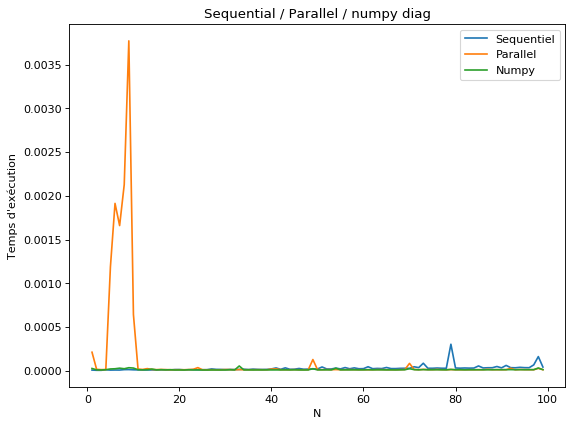

In [8]:
nmax=100
time_f=np.zeros(3)
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
    va = np.random.random(n)
    res = np.zeros((n, n))

    time_f[0]=time.time()
    s_mat_diag(va)
    time_f[0]=time.time()-time_f[0]

    time_f[1]=time.time()
    p_mat_diag(va,res)
    time_f[1]=time.time()-time_f[1]

    time_f[2]=time.time()
    np.diag(va)
    time_f[2]=time.time()-time_f[2]

    df.iloc[n-1,0]=time_f[0]
    df.iloc[n-1,1]=time_f[1]
    df.iloc[n-1,2]=time_f[2]

print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy diag")

### Fonction Eye

**`mat_eye(n)`** : Crée la matrice identité de dimensions `n*n`.

**Code séquentiel**

In [0]:
def s_mat_eye(n):
    
    res = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            if i==j:
                res[i,j]=1
    
    return res

**Code parallélisé**

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_eye(int n, double[:,:] res):
    cdef int i, j 
    # parallélisation
    with cython.nogil, parallel():
        for i in prange(n):
            for j in prange(n):
                if i==j:
                    res[i,j]=1
    
    return res

**Test de vitesse**

In [0]:
n=6
res = np.zeros((n,n))

In [0]:
%timeit s_mat_eye(n)

13.5 µs ± 2.06 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
%timeit p_mat_eye(n, res) 

4.22 µs ± 769 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
%timeit np.eye(n)

9.14 µs ± 1.14 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Mesure et Graphique**

   Résultats séquentiel Résultats parallèle Résultats numpy
1           5.72205e-06         0.000854969     4.00543e-05
2           6.67572e-06         2.28882e-05     1.12057e-05
3           7.62939e-06         1.26362e-05     8.82149e-06
4           8.10623e-06          1.3113e-05     8.82149e-06
5           1.04904e-05          1.3113e-05      1.0252e-05
..                  ...                 ...             ...
95          0.000579119         3.00407e-05     2.88486e-05
96          0.000378847          5.8651e-05     1.45435e-05
97          0.000417948         2.14577e-05     1.45435e-05
98          0.000412703         2.36034e-05     1.50204e-05
99          0.000399113         2.21729e-05     1.45435e-05

[99 rows x 3 columns]


Text(0.5, 1.0, 'Sequential / Parallel / numpy eye')

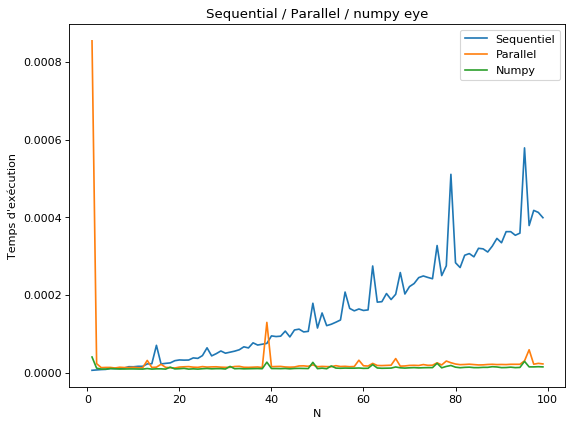

In [11]:
nmax=100
time_f=np.zeros(3)
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
  
    res = np.zeros((n,n))

    time_f[0]=time.time()
    s_mat_eye(n)
    time_f[0]=time.time()-time_f[0]

    time_f[1]=time.time()
    p_mat_eye(n,res)
    time_f[1]=time.time()-time_f[1]

    time_f[2]=time.time()
    np.eye(n)
    time_f[2]=time.time()-time_f[2]

    df.iloc[n-1,0]=time_f[0]
    df.iloc[n-1,1]=time_f[1]
    df.iloc[n-1,2]=time_f[2]

print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy eye")

### Fonction Transpose

**`mat_transpose(a)`** : Transpose la matrice `a`.

**Code séquentiel**

In [0]:
def s_mat_transpose(a):
    n, p = a.shape
    res = np.zeros((p,n))
    
    for i in range(p):
        for j in range(n):
            res[i,j] = a[j,i]
    return res

**Code parallélisé**

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_transpose(double[:,:] a, double[:,:] res):
    cdef int n, p
    n = a.shape[0]
    p = a.shape[1]

    cdef int i, j 
    # parallélisation
    with cython.nogil, parallel():
        for i in prange(p):
            for j in prange(n):
                res[i,j] = a[j,i]
    
    return res

**Test de vitesse**

In [0]:
u = np.random.random((10,20))
res = np.zeros((u.shape[1], u.shape[0]))

In [0]:
%timeit s_mat_transpose(u)

305 µs ± 44 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [0]:
%timeit p_mat_transpose(u, res) 

6.9 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
%timeit np.transpose(u)

2.11 µs ± 530 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


**Mesure et Graphique**

   Résultats séquentiel Résultats parallèle Résultats numpy
1           9.77516e-06          0.00085187     1.69277e-05
2           8.82149e-06          0.00037241     1.04904e-05
3           1.04904e-05         1.57356e-05     6.91414e-06
4           1.38283e-05         1.40667e-05     5.96046e-06
5           1.66893e-05         1.43051e-05     5.96046e-06
..                  ...                 ...             ...
95           0.00330544         5.00679e-05      1.5974e-05
96           0.00312757         3.09944e-05     1.07288e-05
97           0.00325942         3.09944e-05     7.62939e-05
98            0.0036757          4.3869e-05     1.71661e-05
99           0.00338221         3.19481e-05     1.07288e-05

[99 rows x 3 columns]


Text(0.5, 1.0, 'Sequential / Parallel / numpy transpose')

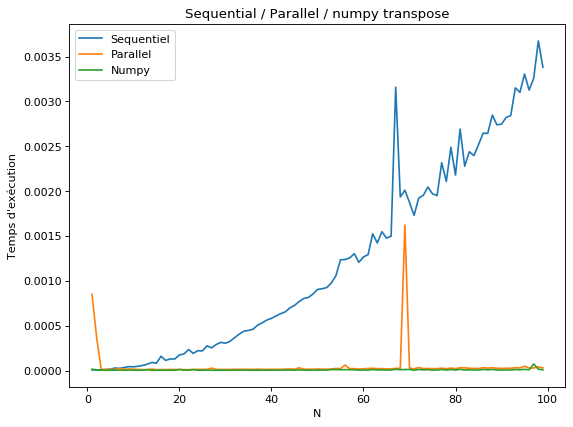

In [14]:
nmax=100
time_f=np.zeros(3)
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
  
    u = np.random.random((n,n))
    res = np.zeros((n,n))

    time_f[0]=time.time()
    s_mat_transpose(u)
    time_f[0]=time.time()-time_f[0]

    time_f[1]=time.time()
    p_mat_transpose(u,res)
    time_f[1]=time.time()-time_f[1]

    time_f[2]=time.time()
    np.transpose(u)
    time_f[2]=time.time()-time_f[2]

    df.iloc[n-1,0]=time_f[0]
    df.iloc[n-1,1]=time_f[1]
    df.iloc[n-1,2]=time_f[2]

print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy transpose")

### Fonction Sum

**`mat_sum(a)`** : Somme les valeurs de la matrice `a`.

**Code séquentiel**

In [0]:
def s_mat_sum(a, axis):
    n, p = a.shape   
    if axis == 0:
        res = np.zeros(p)
        for i in range(p):
            for j in range(n):
                res[i] += a[j,i]
    else:
        res = np.zeros(n)
        for i in range(n):
            for j in range (p):
                res[i] += a[i,j]               
        
    return res

**Code parallélisé**

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_sum(double[:,:] a, int axis, double[:] res):
    cdef int n, p
    n = a.shape[0] 
    p = a.shape[1]
    
    cdef int i, j
    with cython.nogil, parallel():
        if axis == 0:
            for i in prange(p):
                for j in prange(n):
                    res[i] += a[j,i]
        else:
            for i in prange(n):
                for j in prange (p):
                    res[i] += a[i,j]         
    return res

**Test de vitesse**

In [0]:
u = np.random.random((5,10))

In [0]:
%timeit s_mat_sum(u, 0)

89.8 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [0]:
%timeit s_mat_sum(u, 1)

89.2 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [0]:
res = np.zeros(u.shape[1])
%timeit p_mat_sum(u, 1, res) 

8.26 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
res = np.zeros(u.shape[0])
%timeit np.sum(u)

13.7 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
%timeit np.sum(u, 0)

12.1 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [0]:
%timeit np.sum(u, 1)

9.64 µs ± 946 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Mesure et Graphique**

   Résultats séquentiel Résultats parallèle Résultats numpy
1           1.71661e-05           0.0151703     8.29697e-05
2           7.41482e-05          3.6478e-05     3.14713e-05
3           1.52588e-05         1.69277e-05      2.0504e-05
4            2.0504e-05          1.5974e-05     2.36034e-05
5           2.45571e-05         1.38283e-05     1.93119e-05
..                  ...                 ...             ...
95           0.00701213         4.88758e-05     6.93798e-05
96           0.00567436         4.74453e-05     6.62804e-05
97           0.00607443         4.43459e-05     6.55651e-05
98           0.00627971          6.1512e-05     7.05719e-05
99           0.00641775         5.19753e-05     8.44002e-05

[99 rows x 3 columns]


Text(0.5, 1.0, 'Sequential / Parallel / numpy somme')

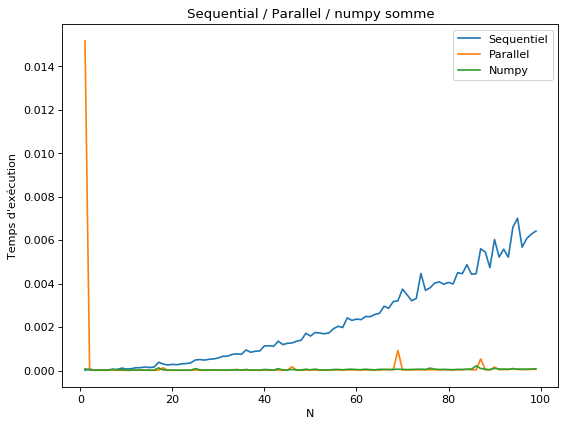

In [17]:
nmax=100
time_f=np.zeros(3)
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
  
    u = np.random.random((n,n))
    res = np.zeros(u.shape[1])

    time_f[0]=time.time()
    s_mat_sum(u,0)
    time_f[0]=time.time()-time_f[0]

    time_f[1]=time.time()
    p_mat_sum(u,0,res)
    time_f[1]=time.time()-time_f[1]

    time_f[2]=time.time()
    np.sum(u,0)
    time_f[2]=time.time()-time_f[2]

    df.iloc[n-1,0]=time_f[0]
    df.iloc[n-1,1]=time_f[1]
    df.iloc[n-1,2]=time_f[2]

print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy somme")

### Fonction Inv

**`mat_inv(a)`** : Inverse la matrice `a`.

**Code séquentiel**

In [0]:
def s_mat_LU(a):
    n = a.shape[0]
    L = np.zeros((n,n))
    U = np.zeros((n,n))
    
    for j in range(n):
        L[j,j] = 1
        U[0,j] = a[0,j]
        
        for i in range(1,n):
            if i>j:
                for k in range(0,j):
                    L[i,j] = L[i,j] + U[k,j] * L[i,k]
                L[i,j] = (a[i,j] - L[i,j]) / U[j,j]
            else:
                for k in range(0,i):
                    U[i,j] = U[i,j] + U[k,j] * L[i,k]
                U[i,j] = a[i,j] - U[i,j]
    return (L,U)

In [0]:
def s_mat_inv(a):
    n = a.shape[0]
    x = np.zeros(n)
    
    d = np.zeros(n)
    L, U = s_mat_LU(a)
    inverse = np.zeros((n,n))
    inv_L = np.zeros((n,n))
    
    # Get inv(L)
    for k in range(n):
        c = np.zeros(n)
        c[k] = 1
        
        for i in range(n):
            somme = 0
            
            for j in range(i): 
                somme += L[i,j] * d[j]

            d[i] = (c[i] - somme) / L[i,i]
        inv_L[:, k] = d
    
        # Get inv(a)
        x [n-1] = d[n-1] / U[n-1, n-1] 

        for i in range(n-2, -1, -1):
            somme = 0

            for j in range(i+1, n):
                somme += U[i,j] * x[j]
            
            x[i] = (d[i] - somme) / U[i,i]
        
        inverse[:,k] = x
        
    return inverse

**Code parallélisé**

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_LU(double[:,:] a, double[:,:] L, double[:,:] U):
    cdef int n
    n = a.shape[0]

    cdef int i, j, k 
    # parallélisation
    with cython.nogil, parallel():
        for j in prange(n):
            L[j,j] = 1
            U[0,j] = a[0,j]
        
            for i in prange(1,n):
                if i>j:
                    for k in prange(0,j):
                        L[i,j] = L[i,j] + U[k,j] * L[i,k]
                    L[i,j] = (a[i,j] - L[i,j]) / U[j,j]
                else:
                    for k in prange(0,i):
                        U[i,j] = U[i,j] + U[k,j] * L[i,k]
                    U[i,j] = a[i,j] - U[i,j]
                    
    return (L, U)     
                    
                    
@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_inv(double[:,:] a, double[:,:] L, double[:,:] U, double[:] d, double[:] c, double[:] x, double[:,:] inverse, double[:,:] inv_L, double[:,:] res):
    cdef int n,p
    cdef double somme 
    
    n = a.shape[0]
    L, U = p_mat_LU(a, L, U)
    
    cdef int k, i, j
    
    # parallélisation
    with cython.nogil, parallel():
        for k in prange(n):
            c[k] = 1
            if k>0:
                c[k-1] = 0
    
            for i in prange(n):
                somme = 0
            
                for j in range(i):
                    somme = somme + L[i,j] * d[j]
                    
                d[i] = (c[i] - somme) / L[i,i]
                
            inv_L[:, k] = d
            
             # Get inv(a)
            x [n-1] = d[n-1] / U[n-1, n-1] 

            for i in prange(n-2, -1, -1):
                somme = 0

                for j in range(i+1, n):
                    somme = somme + U[i,j] * x[j]
            
                x[i] = (d[i] - somme) / U[i,i]
        
            inverse[:,k] = x
                  
    return inverse

**Test de vitesse**

In [0]:
n = 3
u = np.array([[2,1,-1],[4,6,1],[-2,11,8]])
L = np.zeros((n,n))
U = np.zeros((n,n))
d = np.zeros(n)
c = np.zeros(n)
x = np.zeros(n)
inverse = np.zeros((n,n))
inv_L = np.zeros((n,n))
res = np.zeros((n,n))

In [0]:
%timeit s_mat_inv(u)

293 µs ± 72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [0]:
%timeit p_mat_inv(np.double(u), L, U, d, c, x, inverse, inv_L, res)

72.5 µs ± 4.92 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [0]:
%timeit np.linalg.inv(u)

18.7 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Mesure et Graphique**

   Résultats séquentiel Résultats parallèle Résultats numpy
1           3.74317e-05          0.00158334       0.0195758
2            6.4373e-05          0.00839543     0.000622272
3           0.000921249           0.0050168     0.000229597
4           0.000124216          0.00637197      0.00417924
5           0.000375509          0.00188541      0.00474358
..                  ...                 ...             ...
95             0.803694          0.00206828      0.00525784
96             0.793915          0.00235462      0.00650191
97             0.832494          0.00222516       0.0112305
98             0.845046          0.00240874      0.00664234
99             0.868208          0.00227284       0.0113769

[99 rows x 3 columns]


Text(0.5, 1.0, 'Sequential / Parallel / numpy inverse')

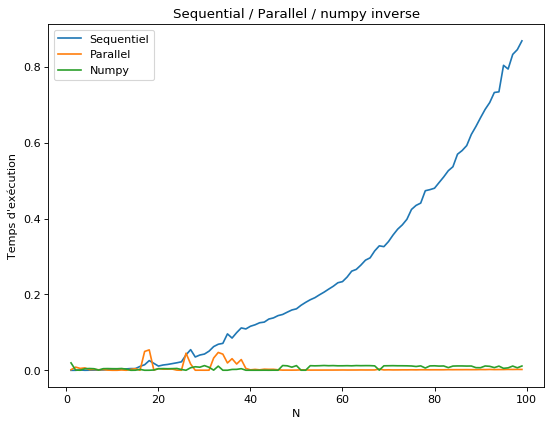

In [21]:
nmax=100
time_f=np.zeros(3)
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
  
    u = np.random.random((n,n))
    L = np.zeros((n,n))
    U = np.zeros((n,n))
    d = np.zeros(n)
    c = np.zeros(n)
    x = np.zeros(n)
    inverse = np.zeros((n,n))
    inv_L = np.zeros((n,n))
    res = np.zeros((n,n))

    time_f[0]=time.time()
    s_mat_inv(u)
    time_f[0]=time.time()-time_f[0]

    time_f[1]=time.time()
    my_memview=p_mat_inv(u, L, U, d, c, x, inverse, inv_L, res)
    time_f[1]=time.time()-time_f[1]
    np.asarray(my_memview)

    time_f[2]=time.time()
    np.linalg.inv(u)
    time_f[2]=time.time()-time_f[2]

    df.iloc[n-1,0]=time_f[0]
    df.iloc[n-1,1]=time_f[1]
    df.iloc[n-1,2]=time_f[2]

print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy inverse")

### Fonction Det

**`mat_det(a)`** : Renvoie le déterminant de la matrice `a`.

In [0]:
from copy import deepcopy
 
def matrice_c(m,i):
    if type(m).__module__ == np.__name__:
        m=m.tolist()  
    mbis = deepcopy(m)
    del(mbis[i])
    for line in mbis:
        del(line[0])
    return mbis
  
def s_mat_det(m):
    return m[0][0] if len(m)==1 else sum(((-1)**i)*m[i][0]*s_mat_det(matrice_c(m,i)) \
           for i in range(0,len(m)))

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
from copy import deepcopy
import cython
from cython.parallel import parallel, prange
import numpy as np 

@cython.boundscheck(False)
@cython.wraparound(False)

def p_matrice_c(m,i):
    if type(m).__module__ == np.__name__:
        m=m.tolist()  
    mbis = deepcopy(m)
    del(mbis[i])
    for line in mbis:
        del(line[0])
    return mbis
  
def p_mat_det(m):
    cdef int i
    return m[0][0] if len(m)==1 else sum(((-1)**i)*m[i][0]*p_mat_det(p_matrice_c(m,i)) \
           for i in range(0,len(m)))

**Test de vitesse**

In [0]:
u = np.array([[2.3,1,-1],[4,6,1],[-2,11,8]])

In [0]:
%timeit s_mat_det(u)

344 µs ± 86.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [0]:
%timeit p_mat_det(u)

346 µs ± 72.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [0]:
%timeit np.linalg.det(u)

20.6 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Mesure et Graphique**

  Résultats séquentiel Résultats parallèle Résultats numpy
1                    0                   0       0.0010035
2                    0                   0               0
3                    0          0.00099659               0
4            0.0019958          0.00199389      0.00101662
5            0.0079782          0.00398755               0
6            0.0309196           0.0458715      0.00100374
7              0.32812            0.142623               0
8               1.3464             1.00532               0
9              11.4115             11.0574               0


Text(0.5, 1.0, 'Sequential / Parallel / numpy det')

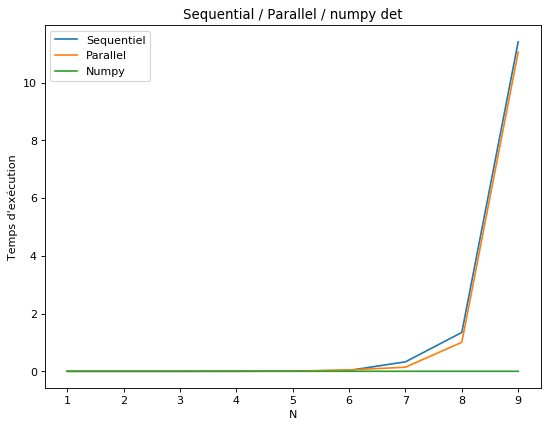

In [0]:
nmax=10
time_f=np.zeros(3)
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
  
    u = np.random.random((n,n))

    time_f[0]=time.time()
    s_mat_det(u)
    time_f[0]=time.time()-time_f[0]

    time_f[1]=time.time()
    p_mat_det(u)
    time_f[1]=time.time()-time_f[1]

    time_f[2]=time.time()
    np.linalg.det(u)
    time_f[2]=time.time()-time_f[2]

    df.iloc[n-1,0]=time_f[0]
    df.iloc[n-1,1]=time_f[1]
    df.iloc[n-1,2]=time_f[2]

print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy det")

### Fonction Tile

**`mat_tile(a, n)`** : Renvoie une matrice qui empile `a` `n`fois.

**Code séquentiel**

In [0]:
def s_mat_tile(a, rep):
    n, p = a.shape
    res = np.zeros((n,p*rep))
    
    for i in range(n):
        for j in range(rep):
            res[i,j*p:j*p+p] = a[i]

    return res

**Code parallélisé**

In [0]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force

import cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)

def p_mat_tile(double[:,:] a, int rep, double[:,:] res):
    cdef int n, p
    n = a.shape[0]
    p = a.shape[1]

    cdef int i, j
    # parallélisation
    with cython.nogil, parallel():
        for i in prange(n):
            for j in prange(rep):
                res[i,j*p:j*p+p] = a[i]
                    
    return res

**Test de vitesse**

In [0]:
n = 10
p = 20
rep = 7
u = np.random.random((n,p))
res = np.zeros((n,p*rep))

In [0]:
%timeit s_mat_tile(u, rep)

131 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [0]:
%timeit p_mat_tile(u, rep, res)

59.5 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [0]:
%timeit np.tile(u,rep)

36 µs ± 7.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Mesure et Graphique**

   Résultats séquentiel Résultats parallèle Résultats numpy
1                     0                   0     0.000996113
2                     0                   0               0
3                     0                   0               0
4                     0                   0               0
5                     0                   0               0
..                  ...                 ...             ...
95                    0                   0               0
96          0.000996828                   0               0
97          0.000997782                   0     0.000999928
98          0.000995874                   0               0
99          0.000993967                   0               0

[99 rows x 3 columns]


Text(0.5, 1.0, 'Sequential / Parallel / numpy det')

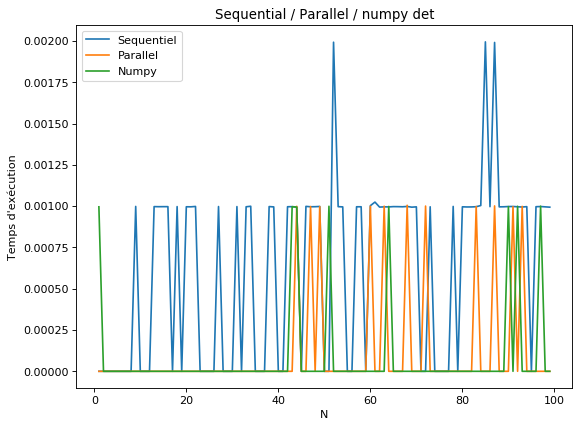

In [0]:
import time

time_f=np.zeros(3)
nmax=100
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

for n in range(1,nmax):
    p = 20
    rep = 7
    u = np.random.random((n,p))
    res = np.zeros((n,p*rep))


    time_f[0]=time.time()
    s_mat_tile(u,rep)
    time_f[0]=time.time()-time_f[0]
    df.iloc[n-1,0]=time_f[0]

    
    time_f[1]=time.time()
    p_mat_tile(u,rep,res)
    time_f[1]=time.time()-time_f[1]
    df.iloc[n-1,1]=time_f[1]

    time_f[2]=time.time()
    np.tile(u,rep)
    time_f[2]=time.time()-time_f[2]
    df.iloc[n-1,2]=time_f[2]


print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Sequential / Parallel / numpy det")

## 5. Gauss PDF

**Code séquentiel**

In [0]:
def s_gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - s_mat_tile(M, X.shape[1])
        E = 0.5 * s_mat_sum(DX * (s_mat_dot(s_mat_inv(S), DX)), 0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(s_mat_det(S))
        P = np.exp(-E)
    elif X.shape[1] == 1:
        DX = s_mat_tile(X, M.shape[1]) - M
        E = 0.5 * s_mat_sum(DX * (s_mat_dot(s_mat_inv(S), DX)), 0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(s_mat_det(S))
        P = np.exp(-E)
    else:
        DX = X - M
        E = 0.5 * s_mat_dot(s_mat_transpose(DX), s_mat_dot(s_mat_inv(S), DX))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(s_mat_det(S))
        P = np.exp(-E)
    return (P[0],E[0]) 

**Code parallélisé**

In [0]:
def p_gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - np.array(p_mat_tile(M, X.shape[1], np.zeros((M.shape[0], M.shape[1] * X.shape[1]))))
        E = 0.5 * np.array(p_mat_sum(DX * p_mat_dot(p_mat_inv(S, np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1])), np.zeros(S.shape[0]), np.zeros(S.shape[0]), np.zeros(S.shape[0]), np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1]))), DX, np.zeros((S.shape[0], DX.shape[1]))), 0, np.zeros(DX.shape[1])))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(p_mat_det(S))
        P = np.exp(-E)
    elif X.shape[1] == 1:
        DX = np.array(p_mat_tile(X, M.shape[1], np.zeros((M.shape[0], M.shape[1] * X.shape[1])))) - M
        E = 0.5 * np.array(p_mat_sum(DX * p_mat_dot(p_mat_inv(S, np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1])), np.zeros(S.shape[0]), np.zeros(S.shape[0]), np.zeros(S.shape[0]), np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1]))), DX, np.zeros((S.shape[0], DX.shape[1]))), 0, np.zeros(DX.shape[1])))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(p_mat_det(S))
        P = np.exp(-E)
    else:
        DX = X - M
        E = 0.5 * np.array(p_mat_dot(p_mat_transpose(DX, np.zeros((DX.shape[1], DX.shape[0]))), p_mat_dot(p_mat_inv(S, np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1])), np.zeros(S.shape[0]), np.zeros(S.shape[0]), np.zeros(S.shape[0]), np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1])), np.zeros((S.shape[0], S.shape[1]))), DX, np.zeros((S.shape[0], DX.shape[1]))), np.zeros((S.shape[1], DX.shape[1]))))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(p_mat_det(S))
        P = np.exp(-E)
    return (P[0],E[0])

**Numpy**

In [0]:
def np_gauss_pdf(X, M, S):
    if M.shape[1] == 1:
        DX = X - np.tile(M, X.shape[1])
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis = 0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    elif X.shape[1] == 1:
        DX = np.tile(X, M.shape[1]) - M
        E = 0.5 * np.sum(DX * (np.dot(np.linalg.inv(S), DX)), axis = 0)
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    else:
        DX = X - M
        E = 0.5 * np.dot(np.transpose(DX), np.dot(np.linalg.inv(S), DX))
        E = E + 0.5 * M.shape[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S))
        P = np.exp(-E)
    return (P[0],E[0])

## 6. Filtre de Kalman

### Phases de prédiction et de mise à jour

#### Fonction de prédiction

**`kf_predict(X, P, A, Q, B, U)`** : Etape de prédiction

**Code séquentiel**

In [0]:
def s_kf_predict(X, P, A, Q, B, U):
    X = s_mat_dot(A, X) + s_mat_dot(B, U)
    P = s_mat_dot(A, s_mat_dot(P, s_mat_transpose(A))) + Q
    return(X, P)

**Code parallélisé**

In [0]:
def p_kf_predict(X, P, A, Q, B, U):
    X = np.array(p_mat_dot(A, X, np.zeros((A.shape[0], X.shape[1])))) \
        + np.array(p_mat_dot(B, U, np.zeros((B.shape[0], U.shape[1]))))
    
    P = np.array(p_mat_dot(A, p_mat_dot(P, p_mat_transpose(A, np.zeros((A.shape[1], A.shape[0]))), \
        np.zeros((P.shape[0], A.shape[0]))), np.zeros((A.shape[0], A.shape[0])))) + Q
    
    return(X, P)

**Numpy**

In [0]:
def np_kf_predict(X, P, A, Q, B, U):
    X = np.dot(A, X) + np.dot(B, U)
    P = np.dot(A, np.dot(P, np.transpose(A))) + Q
    return(X, P)

#### Fonction de mise à jour

**`kf_update(X, P, Y, H, R)`** : Etape de mise à jour

**Code séquentiel**

In [0]:
def s_kf_update(X, P, Y, H, R):
    IM = s_mat_dot(H, X)
    V = Y - IM
    IS = R + s_mat_dot(H, s_mat_dot(P, s_mat_transpose(H)))
    K = s_mat_dot(P, s_mat_dot(s_mat_transpose(H), s_mat_inv(IS)))
    X = X + s_mat_dot(K, V)
    P = P - s_mat_dot(K, s_mat_dot(IS, s_mat_transpose(K)))
    LH = s_gauss_pdf(Y, IM, IS)
    return(X, P, K, IM, IS, LH)

**Code parallélisé**

In [0]:
def p_kf_update(X, P, Y, H, R):
    IM = p_mat_dot(np.double(H), X, np.zeros((H.shape[0], X.shape[1])))
    V = Y - IM
    tH = p_mat_transpose(np.double(H), np.zeros((H.shape[1], H.shape[0])))
    IS = R + np.array(p_mat_dot(np.double(H), p_mat_dot(P, p_mat_transpose(np.double(H), np.zeros((H.shape[1], H.shape[0]))), np.zeros((P.shape[0], H.shape[0]))), \
         np.zeros((H.shape[0], H.shape[0]))))
    iIS = p_mat_inv(IS, np.zeros((IS.shape[0], IS.shape[1])), np.zeros((IS.shape[0], IS.shape[1])), \
          np.zeros(IS.shape[0]), np.zeros(IS.shape[0]), np.zeros(IS.shape[0]), \
          np.zeros((IS.shape[0], IS.shape[1])), np.zeros((IS.shape[0], IS.shape[1])), \
          np.zeros((IS.shape[0], IS.shape[1])))
    K = p_mat_dot(P, p_mat_dot(tH,iIS, np.zeros((tH.shape[0], iIS.shape[1]))), np.zeros((P.shape[0], iIS.shape[1])))
    X = X + p_mat_dot(K, V, np.zeros((K.shape[0], V.shape[1])))
    P = P - p_mat_dot(K, p_mat_dot(IS, p_mat_transpose(K, np.zeros((K.shape[1], K.shape[0]))), \
          np.zeros((IS.shape[0], K.shape[0]))), np.zeros((K.shape[0], K.shape[0])))    
    LH = p_gauss_pdf(Y, IM, IS)
    return(X, P, K, IM, IS, LH)

**Numpy**

In [0]:
def np_kf_update(X, P, Y, H, R):
    IM = np.dot(H, X)
    V = Y - IM
    IS = R + np.dot(H, np.dot(P, np.transpose(H)))
    K = np.dot(P, np.dot(np.transpose(H), np.linalg.inv(IS)))
    X = X + np.dot(K, V)
    P = P - np.dot(K, np.dot(IS, np.transpose(K)))
    LH = np_gauss_pdf(Y, IM, IS)
    return(X, P, K, IM, IS, LH)

### Application

**Code séquentiel**

In [0]:
%%timeit 

#time step of mobile movement
dt = 0.1

# Initialization of state matrices
X = np.array([[0.0], [0.0], [0.1], [0.1]])
P = s_mat_diag((0.01, 0.01, 0.01, 0.01))
A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
Q = s_mat_eye(X.shape[0])
B = s_mat_eye(X.shape[0])
U = np.zeros((X.shape[0],1)) 

# Measurement matrices
Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = s_mat_eye(Y.shape[0])

# Number of iterations in Kalman Filter
N_iter = 50

# Applying the Kalman Filter
for i in range(N_iter):
    (X, P) = s_kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = s_kf_update(X, P, Y, H, R)
    Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]])

56.3 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Code parallélisé**

In [0]:
%%timeit

#time step of mobile movement
dt = 0.1

# Initialization of state matrices
X = np.array([[0.0], [0.0], [0.1], [0.1]])
P = p_mat_diag(np.array([0.01, 0.01, 0.01, 0.01]), np.zeros((np.array([0.01, 0.01, 0.01, 0.01]).shape[0], np.array([0.01, 0.01, 0.01, 0.01]).shape[0])))
A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
Q = p_mat_eye(X.shape[0], np.zeros((X.shape[0], X.shape[0])))
B = p_mat_eye(X.shape[0], np.zeros((X.shape[0], X.shape[0])))
U = np.zeros((X.shape[0],1)) 

# Measurement matrices
Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = p_mat_eye(Y.shape[0], np.zeros((Y.shape[0], Y.shape[0])))

# Number of iterations in Kalman Filter
N_iter = 50

# Applying the Kalman Filter
for i in range(N_iter):
    (X, P) = p_kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = p_kf_update(X, P, Y, H, R)
    Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]])


30.7 ms ± 6.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Numpy**

In [0]:
%%timeit

#time step of mobile movement
dt = 0.1

# Initialization of state matrices
X = np.array([[0.0], [0.0], [0.1], [0.1]])
P = np.diag((0.01, 0.01, 0.01, 0.01))
A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
Q = np.eye(X.shape[0])
B = np.eye(X.shape[0])
U = np.zeros((X.shape[0],1)) 

# Measurement matrices
Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.eye(Y.shape[0])

# Number of iterations in Kalman Filter
N_iter = 50

# Applying the Kalman Filter
for i in range(N_iter):
    (X, P) = np_kf_predict(X, P, A, Q, B, U)
    (X, P, K, IM, IS, LH) = np_kf_update(X, P, Y, H, R)
    Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]])

9.29 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Mesure et Graphique**

*Calcul du temps d'exécution en fonction de la taille de la matrice*

  Résultats séquentiel Résultats parallèle Résultats numpy
3            0.0608366           0.0279212      0.00698066
4              0.16456           0.0598385       0.0129714
5             0.365016            0.186502      0.00598359
6              1.50897             1.36739      0.00596428
7                11.41             7.44305      0.00598335


Text(0.5, 1.0, "Temps d'exécution en fonction de la taille de la matrice")

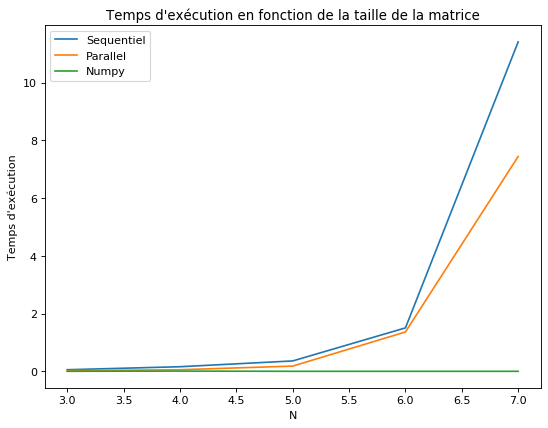

In [0]:
#time step of mobile movement
dt = 0.1
nmax=8
time_f=np.zeros(3)
df=pd.DataFrame(index=range(1,nmax),columns=["Résultats séquentiel", "Résultats parallèle", "Résultats numpy"])

#Séquentiel
for n in range(3,nmax):
    # Initialization of state matrices
    time_f[0]=time.time()
    X=np.zeros((n,1))
    #X[n-2:,1]=0.1
    P = np.zeros((n, n), float)
    np.fill_diagonal(P, 0.01)

    A=np.zeros((n,n))
    H=np.zeros((n,n))
    for i in range(0,n):

        if np.trunc(n/2)==n/2:
            if i < n/2:
                A[i,i]=1
                A[i,i+2]=dt
                H[i,i]=1
            else: 
                A[i,i]=1
        elif np.trunc(n/2)!=n/2:
            if i < np.trunc(n/2)+1:
                A[i,i]=1
                A[i,i+1]=dt
                H[i,i]=1
            else: 
                A[i,i]=1
    
    Q = s_mat_eye(X.shape[0])
    B = s_mat_eye(X.shape[0])
    U = np.zeros((X.shape[0],1)) 

    # Measurement matrices
    Y=X+np.random.randn(n,1)
    R = s_mat_eye(Y.shape[0])

    # Number of iterations in Kalman Filter
    N_iter = 50
    
    # Applying the Kalman Filter
    
    for i in range(N_iter):
        (X, P) = s_kf_predict(X, P, A, Q, B, U)
        (X, P, K, IM, IS, LH) = s_kf_update(X, P, Y, H, R)
        Y=X+0.1*np.random.randn(n,1)
    time_f[0]=time.time()-time_f[0]
    
    df.iloc[n-1,0]=time_f[0]

    #parallèle

    # Initialization of state matrices
    time_f[1]=time.time()
    X=np.zeros((n,1))
    #X[n-2:,1]=0.1
    P = np.zeros((n, n), float)
    np.fill_diagonal(P, 0.01)

    A=np.zeros((n,n))
    H=np.zeros((n,n))
  
    Q = p_mat_eye(X.shape[0], np.zeros((X.shape[0], X.shape[0])))
    B = p_mat_eye(X.shape[0], np.zeros((X.shape[0], X.shape[0])))
    U = np.zeros((X.shape[0],1)) 

    # Measurement matrices
    Y=X+np.random.randn(n,1)
    R = p_mat_eye(Y.shape[0], np.zeros((Y.shape[0], Y.shape[0])))
    
    
    # Applying the Kalman Filte
    for i in range(N_iter):
        (X, P) = p_kf_predict(X, P, A, Q, B, U)
        (X, P, K, IM, IS, LH) = p_kf_update(X, P, Y, H, R)
        Y=X+0.1*np.random.randn(n,1)
    time_f[1]=time.time()-time_f[1]
    
    df.iloc[n-1,1]=time_f[1]

    #numpy
    # Initialization of state matrices
    time_f[2]=time.time()
    X=np.zeros((n,1))
    #X[n-2:,1]=0.1
    P = np.zeros((n, n), float)
    np.fill_diagonal(P, 0.01)

    A=np.zeros((n,n))
    H=np.zeros((n,n))
    
    Q = np.eye(X.shape[0])
    B = np.eye(X.shape[0])
    U = np.zeros((X.shape[0],1)) 

    # Measurement matrices
    Y=X+np.random.randn(n,1)
    R = np.eye(Y.shape[0])
    
    
    # Applying the Kalman Filter
    for i in range(N_iter):
        (X, P) = np_kf_predict(X, P, A, Q, B, U)
        (X, P, K, IM, IS, LH) = np_kf_update(X, P, Y, H, R)
        Y=X+0.1*np.random.randn(n,1)
    time_f[2]=time.time()-time_f[2]
    
    df.iloc[n-1,2]=time_f[2]
    
    
df.drop([1,2], inplace=True)    
print(df)
plt.figure(figsize=(8,6), dpi=80)
plt.plot(df)
plt.legend(['Sequentiel', 'Parallel', 'Numpy'])
plt.xlabel("N")
plt.ylabel("Temps d'exécution")
plt.title("Temps d'exécution en fonction de la taille de la matrice")

*Calcul du temps d'exécution en fonction du nombre d'itérations*

In [0]:
exe_time = np.zeros((100,4))
t = 0 

for N_iter in range(10, 10000, 100):
    
    exe_time[t, 0] = N_iter
    
    
    
    
    # Sequentiel
    start_time = time.time()
    
    #time step of mobile movement
    dt = 0.1

    # Initialization of state matrices
    X = np.array([[0.0], [0.0], [0.1], [0.1]])
    P = s_mat_diag((0.01, 0.01, 0.01, 0.01))
    A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    Q = s_mat_eye(X.shape[0])
    B = s_mat_eye(X.shape[0])
    U = np.zeros((X.shape[0],1)) 

    # Measurement matrices
    Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
    H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    R = s_mat_eye(Y.shape[0])

    # Applying the Kalman Filter
    for i in range(N_iter):
        (X, P) = s_kf_predict(X, P, A, Q, B, U)
        (X, P, K, IM, IS, LH) = s_kf_update(X, P, Y, H, R)
        Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]])
        
    exe_time[t, 1] = time.time() - start_time
    
    
    
    
    # Parallélisé
    start_time = time.time()
    
    #time step of mobile movement
    dt = 0.1

    # Initialization of state matrices
    X = np.array([[0.0], [0.0], [0.1], [0.1]])
    P = p_mat_diag(np.array([0.01, 0.01, 0.01, 0.01]), np.zeros((np.array([0.01, 0.01, 0.01, 0.01]).shape[0], np.array([0.01, 0.01, 0.01, 0.01]).shape[0])))
    A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    Q = p_mat_eye(X.shape[0], np.zeros((X.shape[0], X.shape[0])))
    B = p_mat_eye(X.shape[0], np.zeros((X.shape[0], X.shape[0])))
    U = np.zeros((X.shape[0],1)) 

    # Measurement matrices
    Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
    H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    R = p_mat_eye(Y.shape[0], np.zeros((Y.shape[0], Y.shape[0])))

    # Number of iterations in Kalman Filter
    N_iter = 50

    # Applying the Kalman Filter
    for i in range(N_iter):
        (X, P) = p_kf_predict(X, P, A, Q, B, U)
        (X, P, K, IM, IS, LH) = p_kf_update(X, P, Y, H, R)
        Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]])

    
    exe_time[t, 2] = time.time() - start_time
    
    
    
    
    # Numpy
    start_time = time.time()
    
    #time step of mobile movement
    dt = 0.1

    # Initialization of state matrices
    X = np.array([[0.0], [0.0], [0.1], [0.1]])
    P = np.diag((0.01, 0.01, 0.01, 0.01))
    A = np.array([[1, 0, dt , 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    Q = np.eye(X.shape[0])
    B = np.eye(X.shape[0])
    U = np.zeros((X.shape[0],1)) 

    # Measurement matrices
    Y = np.array([[X[0,0] + abs(np.random.randn(1)[0])], [X[1,0] + abs(np.random.randn(1)[0])]])
    H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    R = np.eye(Y.shape[0])

    # Number of iterations in Kalman Filter
    N_iter = 50

    # Applying the Kalman Filter
    for i in range(N_iter):
        (X, P) = np_kf_predict(X, P, A, Q, B, U)
        (X, P, K, IM, IS, LH) = np_kf_update(X, P, Y, H, R)
        Y = np.array([[X[0,0] + abs(0.1 * np.random.randn(1)[0])],[X[1, 0] + abs(0.1 * np.random.randn(1)[0])]])
    
    exe_time[t, 3] = time.time() - start_time
    
    
    
    
    t += 1

Text(0, 0.5, "Temps d'exécution")

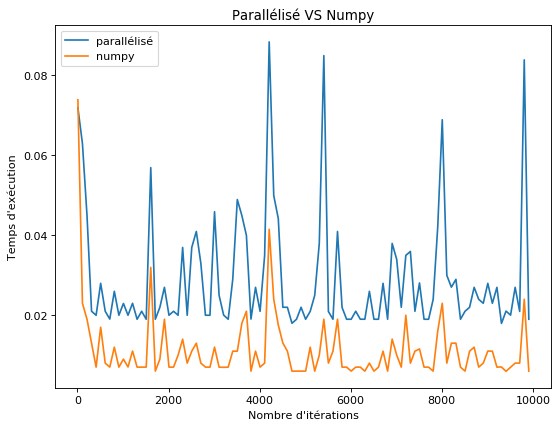

In [0]:
plt.figure(figsize=(8,6), dpi=80)
plt.plot(exe_time[:,0], exe_time[:,2], label='parallélisé')
plt.plot(exe_time[:,0], exe_time[:,3], label = 'numpy')
plt.legend()
plt.title('Parallélisé VS Numpy')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Temps d'exécution")

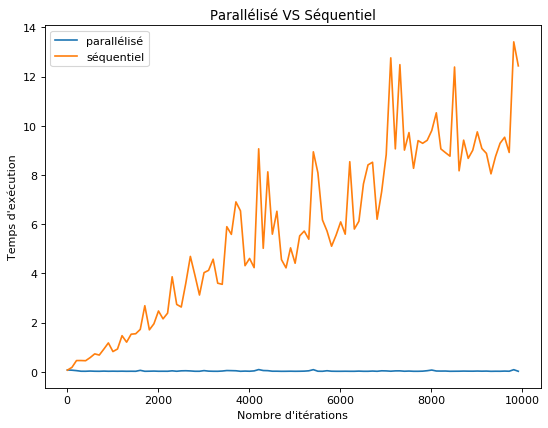

In [0]:
plt.figure(figsize=(8,6), dpi=80)
plt.plot(exe_time[:,0], exe_time[:,2], label='parallélisé')
plt.plot(exe_time[:,0], exe_time[:,1], label = 'séquentiel')
plt.legend()
plt.title('Parallélisé VS Séquentiel')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Temps d'exécution")
plt.show()

## 7. Conclusion

**Calcul matriciel**

Pour chaque fonction que l'on a implémentée on a mesuré leurs temps d'exécution pour une application simple avec une matrice et des paramètres fixés et similaires pour les trois fonctions. On a aussi mesuré l'évolution de leur temps d'exécution en fonction de la taille n de la matrice. 

Globalement, pour chaque fonction la parallélisation améliore le temps d'exécution. Les différents graphiques des mesures nous montrent parfois des pics dans le coût parallèle, cela est dû au fait que la parallélisation a un coût d'implémentation et il faut un certain nombre d'itérations pour qu'elle devienne rentable.

Pour des fonctions simples telles que `mat_diag` ou `mat_eye`, la faible complexité des algorithmes font que les calculs sont peu coûteux pour aucune de nos fonctions ce qui engendre des coûts proches de ceux de numpy. 
Dès que la complexité de l'algorithme et le nombre de calculs dans la fonction augmentent, le coût séquentiel devient linéaire alors que le coût parallèle reste proche de celui de numpy (`mat_dot`, `mat_transpose`, `mat_sum`, `mat_LU`).

Pour ce qui concerne `mat_det` le coût parallèle est un peu inférieur à celui du coût séquentiel mais il suit la même tendance. Cela est dû au fait qu'il n'est pas possible de paralléliser avec Cython un algorithme récursif du fait des conditions GIL que l'on retire. 

**Filtre de Kalman**

Pour la mesure du temps d'exécution du filtre de Kalman, on trouve dans l'application un temps séquentiel à 60.3 ms, parallèle à 33 ms et numpy à 12.9ms. La parallélisation de l'algorithme réduit de moitié le temps d’exécution du filtre mais il n'est toujours pas au niveau de celui de numpy

Dans Mesure et Graphique du filtre de Kalman on a souhaité mesurer les temps d'exécution pour différentes tailles de matrice. Les résultats nous montrent un coût parallèle inférieur au coût séquentiel mais très loin du faible coût de numpy. Cela est peut-être dû au fait qu'en raison de la capacité de nos ordinateurs nous avons été limités dans la taille maximale de la matrice. 

On a ensuite représenté le mesurer le temps d'exécution pour des nombres d'itérations différents. On observe tout d'abord que même si notre algorithme parallélisé n'est pas aussi rapide que Numpy, il le bat néanmoins pour certains nombres d'itérations, et il reste dans la même proportion en terme de vitesse. De plus, la parallélisation permet de largement diminuer le coût par rapport à l'algorithme en séquentiel, et ceux de manière croissante avec le nombre d'itérations. En effet, quelque soit le nombre d'itération, le coût séquentiel reste inférieur à 0.15 secondes, alors que le coût séquentiel est croissant avec le nombre d'itérations et atteint les 20 secondes pour un nombre d'itérations supérieur à 8000.